## Import libraries and dataset

In [1]:
! pip install nltk
! pip install lit-nlp
! pip install umap-learn
! pip install plotly
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
! pip install sentence-transformers
! pip install chromadb
! pip install lime
! pip install lime-python
! pip install shap
! pip install transformers
! pip install vaderSentiment

seed=42

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 30.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.3 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550734 sha256=c8ad221889e03deefd98ec8d5fd

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import re
import nltk
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import chromadb
from chromadb.utils import embedding_functions

from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/'
#file_path = '/content/gdrive/My Drive/Colab Notebooks/dataset/'
# read csv
try:
    data = pd.read_csv(file_path+'all-data.csv', header=None)
    data.columns = ['sentiment', 'text']
    print("File caricato con successo!")
except FileNotFoundError:
    print("Il file non è stato trovato. Assicurati che il percorso sia corretto.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File caricato con successo!


In [6]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [7]:
data.shape

(4846, 2)

## Data Storage and Query

### Tokenization

In [8]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english')
    lower_text = text.lower()                                              # Converting all words into lower case.
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_text = word_tokenize(filtered_text)                            # tokenizethe whole book into words in a list.
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    #return filtered_text
    return ' '.join(filtered_text)

In [9]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))

In [10]:
data.head()

,sentiment,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...


### Transformer encoding

In [11]:
from sentence_transformers import SentenceTransformer

# Carica il modello mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
distilroberta_model = SentenceTransformer('mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')

# Genera gli embedding per ogni documento
data['embedding_distilroberta'] = data['text'].apply(lambda x: distilroberta_model.encode(x))

# Visualizza i primi risultati
print(data[['text', 'embedding_distilroberta']].head())

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

                                                text  \
0  According to Gran , the company has no plans t...   
1  Technopolis plans to develop in stages an area...   
2  The international electronic industry company ...   
3  With the new production plant the company woul...   
4  According to the company 's updated strategy f...   

                             embedding_distilroberta  
0  [-0.2517693, 0.14429943, 0.035337787, 0.221463...  
1  [-0.3444127, 0.31980076, 0.21981314, -0.287868...  
2  [-0.32723272, -0.42913255, 0.49703854, -0.3599...  
3  [0.01898579, 0.40328544, -0.7488608, -0.459687...  
4  [-0.10121163, 0.44934198, -0.61999345, -0.0052...  


In [12]:
data.head()

,sentiment,text,cleaned_text,embedding_distilroberta
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...,"[-0.2517693, 0.14429943, 0.035337787, 0.221463..."
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...,"[-0.3444127, 0.31980076, 0.21981314, -0.287868..."
2,negative,The international electronic industry company ...,international electronic industry company elco...,"[-0.32723272, -0.42913255, 0.49703854, -0.3599..."
3,positive,With the new production plant the company woul...,new production plant company would increase ca...,"[0.01898579, 0.40328544, -0.7488608, -0.459687..."
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...,"[-0.10121163, 0.44934198, -0.61999345, -0.0052..."


In [13]:
data['embedding_distilroberta'].iloc[0].shape

(768,)

### ChromaDB creation and population

In [14]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDBRoberta"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

[]


In [15]:
from chromadb.config import Settings

# onizialie ChromaDB client
client = chromadb.PersistentClient(
    path=pathDB,  # persistence directory
)

# create ChromaDB collection
collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

# load data into collection
for index, row in data.iterrows():
    collection.add(
        ids=[str(index)],  # unique id creation
        documents=[row["text"]],
        metadatas=[{
            "sentiment": row["sentiment"],
            "cleaned_text": row["cleaned_text"]
        }],
        #embeddings=[row["embedding_finbert"]]  # embedding
        embeddings=[row["embedding_distilroberta"]]  # embedding
    )

print("Dataset caricato in ChromaDB con successo!")

Dataset caricato in ChromaDB con successo!


### ChromaDB queries

In [16]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDBRoberta"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

[Collection(name=sentiment_embeddings)]


In [17]:
def search_query(collection, query_text, n_results=3):
    query_embedding = distilroberta_model.encode(query_text)

    # perform the search
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )

    return results

In [18]:
# list of queries
queries = [
    "Silicon Valley's impact on global technology development",
    "Positive solutions in renewable energy",
    "Negative controversies in the automotive industry",
    "Political tensions in Asia-Pacific region",
    "Positive news in the stock market",
    "Issues regarding cybersecurity threats in the financial sector",
    "Celebrity endorsements positively influence brand equity"
]

# dictionary to store results
query_results = {}

# perform searches and store results
for query in queries:
    print("*" * 160)
    print(f"\nQuery: {query}")
    results = search_query(collection, query, n_results=3)  # fetch top 3 results

    # initialize the list to store results for this query
    query_results[query] = []

    # check if results are available
    if 'documents' in results and results['documents']:
        for i, document in enumerate(results['documents']):
            # get the metadata corresponding to the document
            metadata_list = results['metadatas'][i]
            distances = results['distances'][i]

            if isinstance(metadata_list, list):
                for j, metadata in enumerate(metadata_list):
                    # extract the necessary information
                    entry = {
                        "text": document[j],
                        "sentiment": metadata.get('sentiment', 'No sentiment found'),
                        "cleaned_text": metadata.get('cleaned_text', 'No cleaned text found')
                    }
                    query_results[query].append(entry) #add to a dict

                    # print the document, text and metadata
                    print(f"\nDocument {j + 1}:")
                    print(f"Text: {entry['text']}")
                    print(f"Sentiment: {entry['sentiment']}")
                    print(f"Cleaned Text: {entry['cleaned_text']}")
                    print(f"Distance: {distances[j]:.4f}")
                    print("-" * 50)
            else:
                print(f"Metadata for document {i + 1} is not a list. Skipping...")
    else:
        print("No relevant documents found for this query.")

****************************************************************************************************************************************************************

Query: Silicon Valley's impact on global technology development

Document 1:
Text: The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .
Sentiment: neutral
Cleaned Text: engine asia pacific industry profile essential resource top level data analysis cover engine industry
Distance: 73.3166
--------------------------------------------------

Document 2:
Text: As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .
Sentiment: neutral
Cleaned Text: stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry
Distance: 74.5497
--------------------------------------------------

Doc

## Sentiment Classification

In [19]:
for query in queries:
    print(query_results[query])

[{'text': 'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .', 'sentiment': 'neutral', 'cleaned_text': 'engine asia pacific industry profile essential resource top level data analysis cover engine industry'}, {'text': 'As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .', 'sentiment': 'neutral', 'cleaned_text': 'stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry'}, {'text': 'Stockholm , 3 March 2011 About Cybercom The Cybercom Group is a high-tech consultancy that offers global sourcing for end-to-end solutions .', 'sentiment': 'neutral', 'cleaned_text': 'stockholm march cybercom cybercom group high tech consultancy offer global source end end solution'}]
[{'text': 'The GeoSolutions team further provides an intriguing

In [20]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDBRoberta"

client = chromadb.PersistentClient(path=pathDB)  # or HttpClient()
collections = client.list_collections()
print(collections)

[Collection(name=sentiment_embeddings)]


In [21]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# initialize models
#finbert_model = SentenceTransformer('ProsusAI/finbert')
sentiment_classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Device set to use cuda:0


In [22]:
text_result_query = []
cleaned_text_result_query = []
actual_labels = []
predicted_labels = []

# function to classify sentiment
def classify_sentiment(text):
    result = sentiment_classifier(text)[0]  # get the first result (Hugging Face returns a list)
    return result['label'], result['score']

# process each query and classify the sentiment of the documents
for query in query_results:
    print(f"\nQuery: {query}")

    # get the results (documents) for the current query
    results = query_results[query]

    # process each document in the results
    for i, document in enumerate(results):
        text = document['text']
        text_result_query.append(text)
        cleaned_text_result_query.append(document['cleaned_text'])

        # classify sentiment using the Hugging Face model
        classified_sentiment, score = classify_sentiment(text)

        actual_labels.append(document['sentiment'])
        predicted_labels.append(classified_sentiment.lower())

        # print out the results
        print(f"Top {i + 1} document:")
        print(f"Text: {text}")
        print(f"Predicted Sentiment: {classified_sentiment}")
        print(f"Score: {score}")
        print(f"Actual Sentiment: {document['sentiment']}")
        print(f"Cleaned Text: {document['cleaned_text']}")
        print("-" * 50)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Query: Silicon Valley's impact on global technology development
Top 1 document:
Text: The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .
Predicted Sentiment: neutral
Score: 0.999894380569458
Actual Sentiment: neutral
Cleaned Text: engine asia pacific industry profile essential resource top level data analysis cover engine industry
--------------------------------------------------
Top 2 document:
Text: As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .
Predicted Sentiment: neutral
Score: 0.9998922348022461
Actual Sentiment: neutral
Cleaned Text: stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry
--------------------------------------------------
Top 3 document:
Text: Stockholm , 3 March 2011 About Cybercom The Cyberc

In [23]:
actual_labels[:3], predicted_labels[:3]

(['neutral', 'neutral', 'neutral'], ['neutral', 'neutral', 'neutral'])

In [24]:
# confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])

# classification report
report = classification_report(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'], zero_division=1)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    positive       0.67      1.00      0.80         6
     neutral       1.00      0.70      0.82        10
    negative       1.00      1.00      1.00         5

    accuracy                           0.86        21
   macro avg       0.89      0.90      0.87        21
weighted avg       0.90      0.86      0.86        21



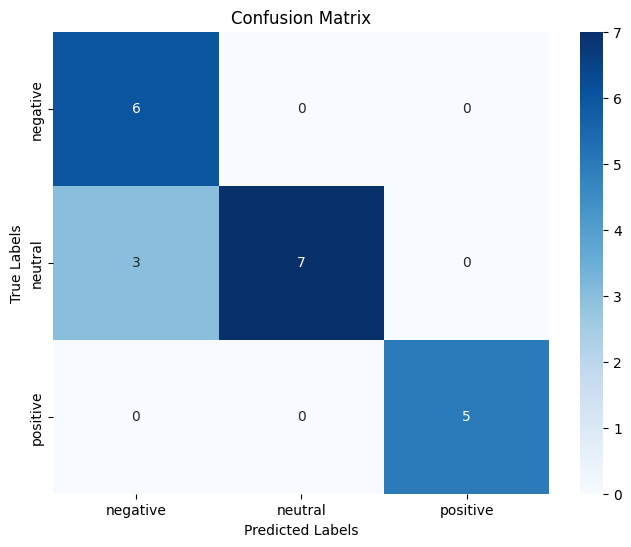

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Explainability

In [26]:
text_result_query[0]

'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .'

In [27]:
cleaned_text_result_query[0]

'engine asia pacific industry profile essential resource top level data analysis cover engine industry'

In [28]:
len(text_result_query), len(cleaned_text_result_query), len(actual_labels), len(predicted_labels)

(21, 21, 21, 21)

In [29]:
query_results[queries[0]][0]['text']

'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .'

In [30]:
query_results[queries[0]]

[{'text': 'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .',
  'sentiment': 'neutral',
  'cleaned_text': 'engine asia pacific industry profile essential resource top level data analysis cover engine industry'},
 {'text': 'As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .',
  'sentiment': 'neutral',
  'cleaned_text': 'stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry'},
 {'text': 'Stockholm , 3 March 2011 About Cybercom The Cybercom Group is a high-tech consultancy that offers global sourcing for end-to-end solutions .',
  'sentiment': 'neutral',
  'cleaned_text': 'stockholm march cybercom cybercom group high tech consultancy offer global source end end solution'}]

The heatmap visualizes the **attention weights** from a transformer model, showing how much attention each token in a text pays to every other token. Here's a breakdown:
- X-axis (horizontal): Represents the source tokens, which are giving attention.

- Y-axis (vertical): Represents the target tokens, which are receiving attention.

Each cell in the matrix, located at row $i$ and column $j$, indicates how much the token $i$ is attending to token $j$. Higher values (lighter colors) mean stronger attention, while lower values (darker colors) mean weaker attention.

The heatmap helps you understand which **tokens influence each other** the most during the model's processing, revealing relationships between words and showing how the model interprets the input text.

When tokenizing input text, the number of tokens you see in the tokenized output may differ from the number of tokens represented in the attention heatmap due to the following reasons:

-    **Padding Tokens**: The model often pads input sequences to a fixed length (e.g., to handle batches of varying lengths). These padding tokens, denoted as [PAD], do not contribute meaningfully to the model’s predictions but are still part of the input sequence and appear in the attention weight matrix. However, since they are not important for the task, they typically receive minimal attention.

- **Special Tokens**: Models like BERT-based transformers add special tokens to the tokenized input:
  - **[CLS] (classification token)** is added at the beginning for classification tasks.
  - **[SEP] (separator token)** is added at the end to separate sentences in tasks involving multiple sentences.

These tokens help the model perform specific tasks, but they may not directly contribute to the sentiment analysis and might not be as relevant in the attention weights, even though they appear in the tokenized input.

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentence: In February the Elcoteq group sold its St Petersburg facility ; according to unconfirmed information the reason could have been supply problems because of the Russian customs service .
Tokens of sentence: ['<s>', 'f', 'eb', 'ruary', 'Ġel', 'c', 'ote', 'q', 'Ġgroup', 'Ġsell', 'Ġst', 'Ġpet', 'ers', 'burg', 'Ġfacility', 'Ġaccord', 'Ġun', 'confirmed', 'Ġinformation', 'Ġreason', 'Ġcould', 'Ġsupply', 'Ġproblem', 'Ġr', 'ussian', 'Ġcustom', 'Ġservice', '</s>']
Prediction: negative, Ground truth: negative


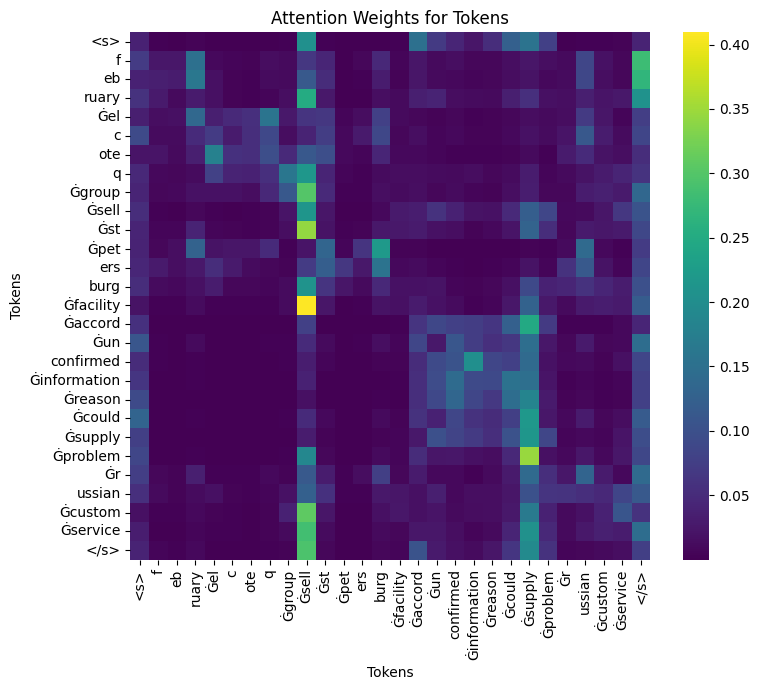

<Figure size 640x480 with 0 Axes>

In [60]:
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

index = 7
#index = 9
#index = 6
#index = 15

model = AutoModel.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", output_attentions=True)
#tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# tokenize queries
inputs = tokenizer(cleaned_text_result_query[index], return_tensors="pt", truncation=True)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(f"Sentence: {text_result_query[index]}")
print(f"Tokens of sentence: {tokens}")
print(f"Prediction: {actual_labels[index]}, Ground truth: {predicted_labels[index]}")

# get attention weights
outputs = model(**inputs)
attentions = outputs.attentions  # List of attention weights for each layer

# extract attention weights for the last layer and first attention head
last_layer_attention = attentions[-1][0][0].detach().numpy()  # Shape: [seq_len, seq_len]

# plot the heatmap with tokens as axis labels
plt.figure(figsize=(8, 7))
sns.heatmap(last_layer_attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis", cbar=True)
plt.title("Attention Weights for Tokens")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.savefig('attention_heatmap.png')

This following piece of code analyzes the attention weights of a transformer model to identify which tokens in the input text are most relevant to the model's decision-making process. The model generates attention scores for each token, showing how much focus it gives to other tokens. These scores are averaged across attention heads and summed for each token to determine its relevance. The top tokens with the highest attention scores are printed and visualized in a bar plot, showing which parts of the text most influence the model's output.

The attention weights from the last layer are typically averaged across all attention heads to simplify the interpretation. Each attention head learns different aspects of the input, and averaging them provides a more generalized view of which tokens the model deems most important for its final decision. This averaged attention gives a clearer, less noisy understanding of the model's focus, helping to identify key tokens influencing the prediction.

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Top tokens by attention relevance:
Token: Ġcould, Attention: 2.6605
Token: Ġun, Attention: 2.4762
Token: </s>, Attention: 2.0494
Token: Ġsell, Attention: 1.7602
Token: Ġproblem, Attention: 1.7382
Token: Ġsupply, Attention: 1.5761
Token: confirmed, Attention: 1.3753
Token: Ġreason, Attention: 1.3014
Token: Ġaccord, Attention: 1.0897
Token: ussian, Attention: 1.0525


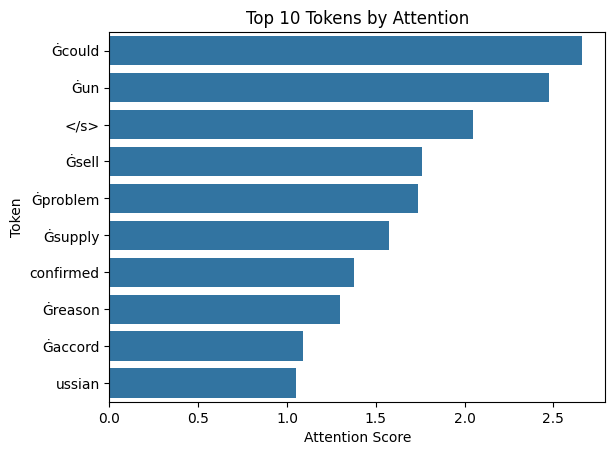

<Figure size 640x480 with 0 Axes>

In [61]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

# load model and tokenizer
model = AutoModel.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", output_attentions=True)
#tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# tokenize query
inputs = tokenizer(cleaned_text_result_query[index], return_tensors="pt", truncation=True, return_offsets_mapping=True)
offset_mapping = inputs.pop("offset_mapping")  # Posizione di ciascun token rispetto al testo originale

# retrieve weights
outputs = model(**inputs)
attentions = outputs.attentions  # Lista dei pesi di attenzione per ogni layer

# take last layer and compute mean
last_layer_attention = attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
avg_attention = last_layer_attention.mean(dim=1)  # Media degli head: [batch_size, seq_len, seq_len]

# sum the attentions for each token
token_relevance = avg_attention[0].sum(dim=0).detach().numpy()  # [seq_len]

# decode tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# order tokens
token_with_relevance = list(zip(tokens, token_relevance))
sorted_tokens = sorted(token_with_relevance, key=lambda x: x[1], reverse=True)

print("Top tokens by attention relevance:")
for token, relevance in sorted_tokens[:10]:  # Primi 10 token
    print(f"Token: {token}, Attention: {relevance:.4f}")

# plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=[t[1] for t in sorted_tokens[:10]], y=[t[0] for t in sorted_tokens[:10]])
plt.title("Top 10 Tokens by Attention")
plt.xlabel("Attention Score")
plt.ylabel("Token")
plt.show()
plt.savefig('attention_barplot.png')

In [62]:
import shap

#tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sentiment_classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# initialize SHAP explainer
explainer = shap.Explainer(sentiment_classifier, tokenizer=tokenizer)

# generate shap values
shap_values = explainer([cleaned_text_result_query[index]])

print(f"Prediction: {actual_labels[index]}, Ground truth: {predicted_labels[index]}")

# visualize shap
shap.text_plot(shap_values)

Device set to use cuda:0


Prediction: negative, Ground truth: negative


# LIT

In [35]:
from lit_nlp import notebook

In [36]:
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types

class RoBERTaWrapper(lit_model.Model):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.max_seq_length = 128  # Puoi modificarlo se necessario

    def max_minibatch_size(self):
        return 16  # Numero massimo di input in batch

    def predict_minibatch(self, inputs):
        # Prepara i dati di input
        encoded = self.tokenizer.batch_encode_plus(
            [ex["text"] for ex in inputs],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.max_seq_length
        )

        # Passa gli input al modello
        with torch.no_grad():
            outputs = self.model(**encoded)

        # Converti i logits in probabilità
        probs = outputs.logits.softmax(dim=-1).detach().numpy()

        # Ritorna i risultati in formato LIT
        return [{"probs": prob} for prob in probs]

    def input_spec(self):
        return {
            "text": lit_types.TextSegment()
        }

    def output_spec(self):
        return {
            "probs": lit_types.MulticlassPreds(
                parent="text",
                vocab=["classe_0", "classe_1"]  # Sostituisci con le etichette del tuo modello
            )
        }

    def predict(self, inputs):
        """
        Perform predictions on all inputs by batching through predict_minibatch.
        """
        # Divide inputs into minibatches
        batch_size = 16
        outputs = []
        for i in range(0, len(inputs), batch_size):
            batch = inputs[i:i + batch_size]
            outputs.extend(self.predict_minibatch(batch))
        return outputs

In [37]:
# Creazione del dizionario con la struttura richiesta
data_dict = [
    {"text": text, "label": label}
    for text, label in zip(text_result_query, actual_labels)
]

# Visualizzare i primi 2 elementi per verificare la struttura
print(data_dict[0])
len(data_dict)

{'text': 'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .', 'label': 'neutral'}


21

In [51]:
from lit_nlp.api import dataset as lit_dataset
from lit_nlp.api import types

# Esempio di un dataset personalizzato
class CustomDataset(lit_dataset.Dataset):
    def _init_(self, data):
        self._examples = data

    def spec(self) -> types.Spec:
        # Specifica le chiavi che il dataset fornisce
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(vocab=["negative", "neutral", "positive"])  # Etichette possibili
        }

    def examples(self):
        return self._examples

# Creare un oggetto dataset
lit_dataset_obj = CustomDataset(data_dict)

In [48]:
!git clone https://github.com/PAIR-code/lit.git

Cloning into 'lit'...
remote: Enumerating objects: 20818, done.
remote: Counting objects: 100% (504/504), done.
remote: Compressing objects: 100% (300/300), done.
remote: Total 20818 (delta 284), reused 212 (delta 204), pack-reused 20314 (from 3)
Receiving objects: 100% (20818/20818), 207.20 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (11976/11976), done.


In [49]:
%cd lit
!apt-get install -y nodejs npm
!cd lit_nlp/client && npm install

/content/lit
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gyp javascript-common libc-ares2 libjs-events libjs-highlight.js libjs-inherits
  libjs-is-typedarray libjs-psl libjs-source-map libjs-sprintf-js libjs-typedarray-to-buffer
  libnode-dev libnode72 libnotify-bin libnotify4 libuv1-dev node-abab node-abbrev node-agent-base
  node-ansi-regex node-ansi-styles node-ansistyles node-aproba node-archy node-are-we-there-yet
  node-argparse node-arrify node-asap node-asynckit node-balanced-match node-brace-expansion
  node-builtins node-cacache node-chalk node-chownr node-clean-yaml-object node-cli-table
  node-clone node-color-convert node-color-name node-colors node-columnify node-combined-stream
  node-commander node-console-control-strings node-copy-concurrently node-core-util-is
  node-coveralls node-cssom node-cssstyle node-debug node-decompress-response node-defaults
  node-del

In [50]:
!cd lit_nlp/client && npm run build


> lit-client@1.3.1 build
> yarn clean && webpack --env production=production --config ./client/webpack/config.js

yarn run v1.22.4
error lit-client@1.3.1: The engine "node" is incompatible with this module. Expected version ">=18.0.0". Got "12.22.9"
error Commands cannot run with an incompatible environment.
info Visit https://yarnpkg.com/en/docs/cli/run for documentation about this command.


In [52]:
from lit_nlp import dev_server
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Inizializza il wrapper per RoBERTa
lit_model = RoBERTaWrapper(model, tokenizer)

# Avvia il server LIT
#lit_server = dev_server.Server(models={"roberta_model": lit_model}, datasets={"my_dataset": data_dict}, port=4321)
#lit_server.serve()
widget = notebook.LitWidget(models={"roberta_model": lit_model}, datasets={"my_dataset": data_dict}, port=8890)

AttributeError: 'list' object has no attribute 'init_spec'

In [ ]:
# Render the widget
widget.render(height=600)

In [ ]:
text_result_query

['The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .',
 'As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .',
 'Stockholm , 3 March 2011 About Cybercom The Cybercom Group is a high-tech consultancy that offers global sourcing for end-to-end solutions .',
 'The GeoSolutions team further provides an intriguing new technology combining GPS and Mobile-based technologies together with Internet-based social networking .',
 "FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .",
 "W+�rtsil+� 's solution has been selected for its low fuel consumption , environmentally sound technology , and global service support .",
 'Aspocomp has a large factory in China an

# transformer interpret

In [77]:
!pip install transformers_interpret
from transformers_interpret import SequenceClassificationExplainer
from transformers_interpret import MultiLabelClassificationExplainer

In [78]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

multiclass_explainer = MultiLabelClassificationExplainer(model=model, tokenizer=tokenizer)

In [81]:
word_attributions = multiclass_explainer(text=cleaned_text_result_query[0])
multiclass_explainer.predicted_class_name

'neutral'

In [82]:
html = multiclass_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.05),negative,-2.46,#s engine as ia pac ific industry profile essential resource top level data analysis cover engine industry #/s
n/a,(1.00),neutral,2.94,#s engine as ia pac ific industry profile essential resource top level data analysis cover engine industry #/s
n/a,(0.04),positive,-1.89,#s engine as ia pac ific industry profile essential resource top level data analysis cover engine industry #/s
